In [1]:
import sys
import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'./')
from importlib import reload
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import default_cosmology
from astropy import units
import astropy
#only for python3
import importlib
reload=importlib.reload

In [2]:
from cov_3X2 import *
from PCA_shear import *

In [3]:
import PCA_shear
reload(PCA_shear)
from PCA_shear import *

In [4]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [5]:
import lsst_utils
reload(lsst_utils)
from lsst_utils import *

In [6]:
fig_home='./figures/'
fig_format='pdf'

In [7]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=1,processes=False,memory_limit='30gb',threads_per_worker=8,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(LC)

In [8]:
from time import sleep
def func(x):
    sleep(2)
    return x+1

In [9]:
%time xx=delayed(func)(10)
yy=xx
sleep(2)

CPU times: user 140 µs, sys: 10 µs, total: 150 µs
Wall time: 143 µs


In [10]:
yy.compute()

11

In [11]:
xx.compute()

11

In [12]:
%time xx=xx.result()

CPU times: user 113 µs, sys: 0 ns, total: 113 µs
Wall time: 111 µs


In [13]:
xx

Delayed('result-1804735f-b6cf-430d-8dda-75c33bf3faf3')

In [14]:
def cosmo_w0_wa(cosmo=None,w0=-1,wa=0):
    attrs=['H0','Om0', 'Ode0','Tcmb0', 'Neff', 'm_nu', 'Ob0']
    args={}
    args['w0']=w0
    args['wa']=wa
    for a in attrs:
        args[a]=getattr(cosmo,a)
    cosmo_w=astropy.cosmology.w0waCDM(**args)
    return cosmo_w
cosmo_w0_wa(cosmo=cosmo)

w0waCDM(H0=67.7 km / (Mpc s), Om0=0.307, Ode0=0.691, w0=-1, wa=0, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [15]:
def cosmo_h_set(cosmo=None,cosmo_params={}):
    if cosmo_params['wa']!=0:
        cosmo=cosmo_w0_wa(cosmo=cosmo,w0=cosmo_params['w'],wa=cosmo_params['wa'])
    cosmo2=cosmo.clone(H0=cosmo_params['h']*100,
                        Om0=cosmo_params['Om'],
                       Ob0=cosmo_params['Omb'],
#                        Odm0=cosmo_params['Omd'],
#                        Ok0=cosmo_params['Omk'],
#                        w=cosmo_params['w'],
                       m_nu=[0,0,cosmo_params['mnu']]*units.eV
                    )

In [16]:
def get_x_var(x0=None,dx_max=0.01,do_log=False,Nx=2):
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    if do_log:
        x0=np.absolute(x0)
        x_vars=x0**Dx
        if x0==1:
            x_vars=(2.**Dx)/2. # 1**x=1
        if x0==0:
            x_vars=np.logspace(-3,-2,Nx)
        x_vars*=np.sign(cosmo_fid[p])
        x_grad=np.gradient(np.log(x_vars))
    else:
        x_vars=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
        if x0==0:
            x_vars=Dx-1
        x_grad=np.gradient(x_vars)
    return x_vars,x_grad

In [17]:
def fish_cosmo_model(p='As',Nx=2,dx_max=0.01,do_log=False,kappa_class=None,do_cov=False):
    x0=cosmo_fid[p]

    models={}
    covs={}
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    print(p,x_vars)
    for i in np.arange(Nx):
        cosmo_t=cosmo_fid.copy()

        cosmo_t[p]=x_vars[i]

        if p=='s8':
            s80=cosmo_fid['s8']
            cosmo_t['As']*=(cosmo_t['s8']/s80)**2
            kappa_class.Ang_PS.PS.get_pk(z=[0],cosmo_params=cosmo_t,return_s8=True)
            kappa_class.Ang_PS.PS.pk=None
            x_vars[i]=kappa_class.Ang_PS.PS.s8
#                 print(x_vars[p][i],s80,cosmo_t['s8'])
        cosmo_h2=cosmo_h_set(cosmo=cosmo,cosmo_params=cosmo_t)
        cl0G=kappa_class.cl_tomo(cosmo_params=cosmo_t,cosmo_h=cosmo_h2)
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    return models,covs,x_vars,x_grad

In [65]:
def set_zbin_bias0(zs_bins={},bias=0):
    bias0=np.copy(zs_bins['zp_bias'])
    bias0=bias*(1+zs_bins['zp'])
    return bias0

def set_zbin_bias(zs_bins={},bias=0,bin_id=0):
    bias0=np.copy(zs_bins['zp_bias'])
    idx=np.digitize(zs_bins['zp'],zs_bins['z_bins'])-1
    bias0[np.where(idx==bin_id)]=bias
    return bias0

def set_zbin_sigma(zs_bins={},zsigma_frac=1,bin_id=0):
    zp_sigma=np.copy(zs_bins['zp_sigma'])
    idx=np.digitize(zs_bins['zp'],zs_bins['z_bins'])-1
    zp_sigma[np.where(idx==bin_id)]=zp_sigma[np.where(idx==bin_id)]*zsigma_frac
    return zp_sigma
    
def fish_z_model(p='b1',Nx=2,dx_max=0.01,kappa_class=None,do_cov=False,do_log=False,zs_bins_kwargs0={}):
    zs_bins_kwargs=zs_bins_kwargs0.copy()
    zs_bins=lsst_source_tomo_bins(**zs_bins_kwargs)
    if 'b' in p:
        x0=0
    else:
        x0=1
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        zs_bins_t=zs_bins.copy()
        if 'B' in p:
            bias=set_zbin_bias0(zs_bins=zs_bins,bias=x_vars[i])
            zs_bins_kwargs['z_bias']=bias
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
        if 'b' in p:
            bin_id=np.int(p[-1])
            bias=set_zbin_bias(zs_bins=zs_bins,bias=x_vars[i],bin_id=bin_id)
            zs_bins_kwargs['z_bias']=bias
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
        if 'sig' in p:
            bin_id=np.int(p[-1])
            zp_sigma=set_zbin_sigma(zs_bins=zs_bins,zsigma_frac=x_vars[i],bin_id=0)
            zs_bins_kwargs['z_sigma']=zp_sigma
            zs_bins_i=lsst_source_tomo_bins(**zs_bins_kwargs)
        kappa_class.update_zbins(z_bins=zs_bins_i,tracer='shear')
        cl0G=kappa_class.cl_tomo()
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
    kappa_class.update_zbins(z_bins=zs_bins,tracer='shear')
    return models,covs,x_vars,x_grad

In [66]:
def fish_galaxy_model(p='b11',Nx=2,dx_max=0.01,kappa_class=None,do_cov=False,do_log=False,zg_bins_kwargs0={}):
    
    z_bins=kappa_class.z_bins['galaxy']
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)

    if 'b' in p:
        bin_indx=np.int(p[-1])
        x0=kappa_class.z_bins['galaxy'][bin_indx][p[:-1]]
    else:
        pass
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)    
    
    models={}
    covs={}
    print(p,x_vars)
    for i in np.arange(Nx):
        z_bins_t=z_bins.copy()
        if 'b' in p:
            z_bins_t[bin_indx][p[:-1]]=x_vars[i]
        
        kappa_class.update_zbins(z_bins=z_bins_t,tracer='galaxy')
        cl0G=kappa_class.cl_tomo()
        cl_t=cl0G['stack'].compute()
        models[i]=cl_t['cl_b']
        covs[i]=cl_t['cov']
        kappa_class.Ang_PS.reset()
        z_bins_t[bin_indx][p[:-1]]=x0
    kappa_class.update_zbins(z_bins=z_bins,tracer='galaxy')
    return models,covs,x_vars,x_grad    

In [20]:
def fish_baryon_model(p='Q1',Nx=2,dx_max=0.01,kappa_class=None,clS=None,cl0=None,do_cov=False,do_log=False,
                      zg_bins_kwargs0={},NmarQ=2):
    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)

    if 'Q' in p:
        Q_indx=np.int(p[-1])
        x0=0
    else:
        pass
    x_vars,x_grad=get_x_var(x0=x0,dx_max=dx_max,do_log=do_log,Nx=Nx)    
    
    models={}
    covs={}
    cov_F=1.#/np.median(np.diag(clS['cov']))
    print(p,clS['cov'].shape,np.linalg.det(clS['cov']*cov_F))
    
    PCS=PCA_shear(kappa_class=kappa_class,NmarQ=NmarQ,clS=clS)
    
    for i in np.arange(Nx):
        Q0=[0]*NmarQ
        Q0[Q_indx]=x_vars[i]
        
        cl_t=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=Q0)
        models[i]=np.zeros_like(cl0) #this is needed to keep everything in right shape. Baryon stuff is only for shear right now. 
        models[i][:len(cl_t)]+=cl_t #['cl_b']
        models[i][len(cl_t):]+=cl0[len(cl_t):]
        print(models[i].shape,PCS.COV.shape)
        covs[i]=PCS.COV
        kappa_class.Ang_PS.reset()
    return models,covs,x_vars,x_grad    

# PCS=PCA_shear(kappa_class=kappa_class,NmarQ=3)
# cl_t1=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=[-10,-10,-10])
# cl_t0=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=[0,0,0])

In [21]:
def fisher_calc(cosmo_params=['As'],z_params=[],galaxy_params=[],baryon_params=[],Nx=2,dx_max=0.01,do_log=False,
                kappa_class=None,do_cov=False,baryon_PCA_nQ=2,
               cov_3X2_kwargs={},zs_bins_kwargs={},ell_bin_kwargs={},cl0=None,priors=None):
    
    if kappa_class is None:
        zs_bins=lsst_source_tomo_bins(**zs_bins_kwargs)
        l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
        kappa_class=cov_3X2(l=l0,l_bins=l_bins,zs_bins=zs_bins,**cov_3X2_kwargs)
        
    do_cov0=np.copy(kappa_class.do_cov)
    kappa_class.do_cov=True #need covariance to start things.
    
    cl0G=kappa_class.cl_tomo()
    
    clS=cl0G['stack'].compute()
#     cl_t=client.submit(cl0G['stack'])
    cl0=clS['cl_b']
    
    cl_shear=delayed(kappa_class.stack_dat)(dat={'cov':cl0G['cov'],'cl_b':cl0G['cl_b'],'est':'cl_b'},corrs=[corr_ll])
    cl_shear=cl_shear.compute()
#     cl_t=client.submit(cl0G['stack'])

    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    cosmo_h=kappa_class.Ang_PS.PS.cosmo_h.clone()
    cov=clS['cov']
    kappa_class.Ang_PS.reset()
    
    kappa_class.do_cov=do_cov

    ndim=len(cosmo_params)+len(z_params)+len(galaxy_params)+len(baryon_params)
    params_all=np.append(np.append(cosmo_params,z_params),galaxy_params)
    params_all=np.append(params_all,baryon_params)
    params_all=np.append(params_all,AI_params)
    params_all=np.append(params_all,mag_params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    cov_derivs={}
    x_grads={}
    for p in cosmo_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_cosmo_model(p=p,Nx=Nx,dx_max=dx_max,do_log=do_log,
                                                     kappa_class=kappa_class,do_cov=do_cov)
    for p in z_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_z_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,zs_bins_kwargs0=zs_bins_kwargs)
    
    for p in galaxy_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_galaxy_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,
                                                 do_cov=do_cov,zg_bins_kwargs0=zs_bins_kwargs)
    
    for p in baryon_params:
        models[p],covs[p],x_vars[p],x_grads[p]=fish_baryon_model(p=p,Nx=Nx,dx_max=dx_max,
                                                 kappa_class=kappa_class,clS=cl_shear,cl0=cl0,
                                                 do_cov=do_cov,NmarQ=baryon_PCA_nQ)
    
    for p in params_all:
        model_derivs[p]=np.gradient(np.array([models[p][i] for i in np.arange(Nx)]),axis=0).T
        model_derivs[p]/=x_grads[p]
        model_derivs[p]=model_derivs[p][:,np.int(Nx/2)]
        
        if do_cov:
            cov_derivs[p]=np.gradient(np.array([covs[p][i] for i in np.arange(Nx)]),axis=0).T
            cov_derivs[p]/=x_grads[p]
#             print(cov_derivs[p].shape,x_grad.shape)
            cov_derivs[p]=cov_derivs[p][:,:,np.int(Nx/2)]
    
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params_all:
        i2=0
        for p2 in params_all:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            
            if do_cov:
#                 print(cov_p_inv[i1,i2],0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2]))
                cov_p_inv[i1,i2]+=0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2])
            i2+=1
        i1+=1
    out={}
    out['cov_p_inv']=np.copy(cov_p_inv)
    if priors is not None:
        i2=0
        for p1 in params_all:
            cov_p_inv[i2,i2]+=1./priors[p1]**2
            i2+=1
    try:
        out['cov_p']=np.linalg.inv(cov_p_inv)
        out['error']=np.sqrt(np.diag(out['cov_p']))
    except Exception as err:
        print(err)

        
    out['cov_deriv']=cov_derivs
    out['model_deriv']=model_derivs
    out['cov']=cov
    out['cov_inv']=cov_inv
    out['model']=models
    out['x_vars']=x_vars
    out['params']=params_all
    kappa_class.do_cov=do_cov0
    return out

In [22]:
def fish_apply_priors(cosmo_params=[],z_params=[],galaxy_params=[],baryon_params=[],priors=None,fish=[]):
    ndim=len(cosmo_params)+len(z_params)+len(galaxy_params)+len(baryon_params)
    params_all=np.append(np.append(cosmo_params,z_params),galaxy_params)
    params_all=np.append(params_all,baryon_params)
    
    cov_p_inv=np.copy(fish['cov_p_inv'])
    
    i2=0
    for p1 in params_all:
        cov_p_inv[i2,i2]+=1./priors[p1]**2
        i2+=1
    try:
        fish['cov_p_prior']=np.linalg.inv(cov_p_inv)
        fish['error_prior']=np.sqrt(np.diag(fish['cov_p_prior']))
    except Exception as err:
        print(err)
    return fish

In [23]:
k='corrs3_zmin0_barynQ2_pkfclass_pk_SSVFalse'

In [24]:
def get_cl_ells(lmax_cl=5000,lmin_cl=2,Nl_bins=40):
    l0=np.arange(lmin_cl,lmax_cl)

    lmin_cl_Bins=lmin_cl+10
    lmax_cl_Bins=lmax_cl-10
    l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
    

    l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
    return l0,l_bins,l


In [25]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
corrs=[corr_ll] #[corr_ggl,corr_gg,corr_ll]

In [47]:
z_min_iter=[0,0.3]
z_max_iter=[3,2]
corrs_iter=[[corr_ll],[corr_ll,corr_ggl,corr_gg]]
pk_iter=['class_pk','baryon_pk']
SSV_iter=[False,True]
nz_iter=[26,20,50]
nbins_iter=[3,1,5]
l_max_iter=[2000,1000,5000]
bary_nQ_iter=[0,2,1,3,5]

cosmo_params=np.atleast_1d(['Ase9','Om','w','wa'])
pz_iter=[[],'pzb']

def init_fish(z_min=z_min_iter[0],z_max=z_max_iter[0],corrs=corrs_iter[0],SSV=SSV_iter[0],
              pk_func=pk_iter[0],nz=nz_iter[0],nbins=nbins_iter[0],
              l_max=l_max_iter[0],l_min=2,Nl_bins=40,
             n_lens_bins=3,nlens0=10):
    
    power_spectra_kwargs2=power_spectra_kwargs.copy()
    power_spectra_kwargs2['pk_func']=pk_func
    
    cov_3X2_kwargs={'do_cov':do_cov,'bin_cl':bin_cl, #'l':l0,'l_bins':l_bins,
            'SSV_cov':SSV,'tidal_SSV_cov':SSV,'do_xi':False,'use_window':use_window,
            'f_sky':f_sky,#'sigma_gamma':sigma_gamma,
                    'corrs':corrs,
            'do_sample_variance':do_sample_variance,'power_spectra_kwargs':power_spectra_kwargs2,
            'bin_xi':bin_xi}
    
    zs_bins_kwargs={'zmin':z_min,'zmax':z_max,'ns0':nz,'nbins':nbins,'z_sigma':0.05,'z_sigma_power':1,
                    'use_window':use_window}
    ell_bin_kwargs={'lmax_cl':l_max,'lmin_cl':l_min,'Nl_bins':Nl_bins}
    zs_bins=lsst_source_tomo_bins(**zs_bins_kwargs)
    
    zl_bins=lsst_source_tomo_bins(ns0=nlens0,nbins=n_lens_bins,
                         ztrue_func=ztrue_given_pz_Gaussian,use_window=use_window,
                        z_sigma=0.005)
    for i in np.arange(n_lens_bins):
        zl_bins[i]['b1']=1
        
    cov_3X2_kwargs['zg_bins']=zl_bins
    
    l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
    kappa_class=cov_3X2(l=l0,l_bins=l_bins,zs_bins=zs_bins,**cov_3X2_kwargs)
    return kappa_class

In [48]:
#setup parameters
l0,l_bins,l=get_cl_ells()
lb=0.5*(l_bins[1:]+l_bins[:-1])

do_cov=True
bin_cl=True

SSV_cov=True
tidal_SSV_cov=False

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [49]:
zmin=0.3
zmax=2

# z=np.linspace(0,5,200)
# pzs=lsst_pz_source(z=z)
# x=z<zmax
# x*=z>zmin
# z=z[x]
# pzs=pzs[x]

# ns0=26 #26+np.inf #ns=inf means shape noise is zero
# nbins=3  # Number of tomographic bins
# z_sigma=0.03
# zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
#                          ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

# ng0=10 #26+np.inf #ns=inf means shape noise is zero
# nlbins=1  # Number of tomographic bins
# z_sigma=0.005
# zl_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ng0,nz_bins=nlbins,
#                          ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))
# for i in np.arange(nlbins):
#     zl_bins[i]['b1']=1

In [50]:

do_cov=True
bin_cl=True
SSV_cov=True
tidal_SSV=False
do_sample_variance=True
use_window=False

sigma_gamma=0.26
area=15000
f_sky=area*d2r**2/4/np.pi

In [51]:
power_spectra_kwargs={'pk_func':'baryon_pk'}

In [52]:
power_spectra_kwargs

{'pk_func': 'baryon_pk'}

In [53]:
def func(x):
    sleep(5)
    return x+1

In [54]:
kappa_class=init_fish()
cl0G=kappa_class.cl_tomo()
lb=0.5*(l_bins[1:]+l_bins[:-1])
# cl0=cl0G['stack'].compute()

ns0:  26.0
ns0:  10.0
cl dict done


In [55]:
# PCS=PCA_shear(kappa_class=kappa_class,NmarQ=3)
# cl_t1=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=[-10,-10,-10])
# cl_t0=PCS.compute_modelv_bary(cosmo_params=cosmo_fid,Q=[0,0,0])

In [56]:
priors={}
priors['Ase9']=np.inf
priors['Om']=np.inf
priors['w']=np.inf
priors['wa']=np.inf

In [57]:
priors['B']=0.001 #bias =B*(1+z) 

for i in np.arange(10): #photo-z bias
    priors['b'+str(i)]=0.001

for i in np.arange(10):#galaxy bias
    priors['b1'+str(i)]=1
for i in np.arange(10): #galaxy bias, b2
    priors['b2'+str(i)]=1

for i in np.arange(10): #baryon PCA
    priors['Q'+str(i)]=100


priors['sig0']=0.1
priors['sig1']=0.1
priors['sig2']=0.1

In [58]:
nbins=3
n_lens_bins=4

In [59]:
bary_nQ_iter[3:]

[3, 5]

In [60]:
z_min_iter

[0, 0.3]

In [61]:
cosmo_fid

{'h': 0.6774,
 'Omb': 0.0486,
 'Omd': 0.2589,
 's8': 0.817,
 'Om': 0.3075,
 'Ase9': 2.2,
 'mnu': 0.06,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'w': -1,
 'wa': 0,
 'Oml': 0.6925}

In [ ]:
fishes={}
for corrs in [corrs_iter[1]]:#,corrs_iter[1]]:         
    for z_min in [z_min_iter[1]]:
#         for z_max in z_max_iter:
#             for nz in nz_iter:
#                 ke+='_nz'+str(nz)
#                 for nbins in nbins_iter:
#                     ke+='_nb'+str(nbins)
                    for bary_nQ in bary_nQ_iter:
                        baryon_params=[]
                        if bary_nQ>0:
                            baryon_params=['Q{j}'.format(j=i) for i in np.arange(bary_nQ)]
                        for pk_func in pk_iter: 
                            for SSV in SSV_iter:
                                kappa_class=init_fish(corrs=corrs,z_min=z_min,#z_max=z_max,nz=nz,
                                                      nbins=nbins,pk_func=pk_func,SSV=SSV)
                                for pz in pz_iter:
                                    pz_params=['b{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['shear']['n_bins'])] if 'pzb' in pz else pz

                                    galaxy_params=[]
                                    if len(corrs)>1:
                                        galaxy_params=['b1{j}'.format(j=i) for i in np.arange(kappa_class.z_bins['galaxy']['n_bins'])]

                                    ke='corrs'+str(len(corrs))
                                    ke=ke+'_zmin'+str(z_min)
                                    ke+='_barynQ'+str(bary_nQ)
                                    ke+='_pkf'+str(pk_func)
                                    ke+='_SSV'+str(SSV)
                                    ke=ke+'_pz'+str(pz) if 'pzb' in pz else ke
                                    
                                    print('doing ',ke)
                                    #crash
                                    fishes[ke]=fisher_calc(cosmo_params=cosmo_params,z_params=pz_params,
                                                           do_cov=False,do_log=False,
                                                           kappa_class=kappa_class,galaxy_params=galaxy_params,
                                                           baryon_params=baryon_params,baryon_PCA_nQ=bary_nQ
                                            )
                                    try:
                                        fishes[ke]=fish_apply_priors(fish=fishes[ke],cosmo_params=cosmo_params,baryon_params=baryon_params,z_params=pz_params,
                                                                     galaxy_params=galaxy_params,priors=priors)
                                        print(ke,' done')
                                    except Exception as err:
                                        print(err)

ns0:  26.0
ns0:  10.0
doing  corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVFalse
cl dict done
Ase9 [2.178 2.222]
cl dict done
cl dict done
Om [0.304425 0.310575]
cl dict done
cl dict done
w [-0.99 -1.01]
cl dict done
cl dict done
wa [-0.01  0.01]
cl dict done
cl dict done
b10 [0.99 1.01]
cl dict done
cl dict done
b11 [0.99 1.01]
cl dict done
cl dict done
b12 [0.99 1.01]
cl dict done
cl dict done
corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVFalse  done
doing  corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVFalse_pzpzb
cl dict done
Ase9 [2.178 2.222]
cl dict done
cl dict done
Om [0.304425 0.310575]
cl dict done
cl dict done
w [-0.99 -1.01]
cl dict done
cl dict done
wa [-0.01  0.01]
cl dict done
cl dict done
ns0:  27.0
b0 [-0.01  0.01]
ns0:  27.0
cl dict done
ns0:  27.0
cl dict done
ns0:  27.0
b1 [-0.01  0.01]
ns0:  27.0
cl dict done
ns0:  27.0
cl dict done
ns0:  27.0
b2 [-0.01  0.01]
ns0:  27.0
cl dict done
ns0:  27.0
cl dict done
b10 [0.99 1.01]
cl dict done
cl dict done
b11 [0.99 1.01]
cl dict done
cl dict don

cl dict done
ns0:  27.0
cl dict done
b10 [0.99 1.01]
cl dict done
cl dict done
b11 [0.99 1.01]
cl dict done
cl dict done
b12 [0.99 1.01]
cl dict done
cl dict done
Q0 (234, 234) 0.0
cl dict done
COV rescaled for Cholesky... check the results.  1.707729823899567e+20 0.0 1.0000000000048113
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
(819,) (234, 234)
cl dict done
(819,) (234, 234)
Q1 (234, 234) 0.0
cl dict done
COV rescaled for Cholesky... check the results.  1.707729823899567e+20 0.0 1.0000000000048113
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
(819,) (234, 234)
cl dict done
(819,) (234, 234)
corrs3_zmin0.3_barynQ2_pkfclass_pk_SSVTrue_pzpzb  done
ns0:  26.0
ns0:  10.0
doing  corrs3_zmin0.3_barynQ2_pkfbaryon_pk_SSVFalse
cl dict done
Ase9 [2.178 2.222]
cl dict done
cl dict done
Om [0.304425 0.310575]
cl dict done
cl dic

cl dict done
ns0:  27.0
cl dict done
ns0:  27.0
b1 [-0.01  0.01]
ns0:  27.0
cl dict done
ns0:  27.0
cl dict done
ns0:  27.0
b2 [-0.01  0.01]
ns0:  27.0
cl dict done
ns0:  27.0
cl dict done
b10 [0.99 1.01]
cl dict done
cl dict done
b11 [0.99 1.01]
cl dict done
cl dict done
b12 [0.99 1.01]
cl dict done
cl dict done
Q0 (234, 234) 0.0
cl dict done
COV rescaled for Cholesky... check the results.  1.707729823899567e+20 0.0 1.0000000000048113
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
(819,) (234, 234)
cl dict done
(819,) (234, 234)
corrs3_zmin0.3_barynQ1_pkfclass_pk_SSVTrue_pzpzb  done
ns0:  26.0
ns0:  10.0
doing  corrs3_zmin0.3_barynQ1_pkfbaryon_pk_SSVFalse
cl dict done
Ase9 [2.178 2.222]
cl dict done
cl dict done
Om [0.304425 0.310575]
cl dict done
cl dict done
w [-0.99 -1.01]
cl dict done
cl dict done
wa [-0.01  0.01]
cl dict done
cl dict done
b10 [0.99 1.01]
cl dict done
cl dict done
b11 [0.99 1.01]
cl

distributed.worker - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 24.20 GB -- Worker memory limit: 30.00 GB
distributed.worker - WARNING - Worker is at 74% memory usage. Resuming worker. Process memory: 22.40 GB -- Worker memory limit: 30.00 GB


Ase9 [2.178 2.222]
cl dict done
cl dict done
Om [0.304425 0.310575]
cl dict done
cl dict done
w [-0.99 -1.01]
cl dict done
cl dict done
wa [-0.01  0.01]
cl dict done
cl dict done
b10 [0.99 1.01]
cl dict done
cl dict done
b11 [0.99 1.01]
cl dict done
cl dict done
b12 [0.99 1.01]
cl dict done
cl dict done
Q0 (234, 234) 0.0
cl dict done
COV rescaled for Cholesky... check the results.  1.707729823899567e+20 0.0 1.0000000000048113
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
(819,) (234, 234)
cl dict done
(819,) (234, 234)
Q1 (234, 234) 0.0
cl dict done
COV rescaled for Cholesky... check the results.  1.707729823899567e+20 0.0 1.0000000000048113
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
cl dict done
(819,) (234, 234)
cl dict done
(819,) (234, 234)
Q2 (234, 234) 0.0
cl dict done
COV rescaled for Cholesky... check the results.  1.70772

In [71]:
fishes.keys()

dict_keys(['corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVFalse', 'corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVFalse_pzpzb', 'corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVTrue', 'corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVTrue_pzpzb', 'corrs3_zmin0.3_barynQ0_pkfbaryon_pk_SSVFalse', 'corrs3_zmin0.3_barynQ0_pkfbaryon_pk_SSVFalse_pzpzb', 'corrs3_zmin0.3_barynQ0_pkfbaryon_pk_SSVTrue', 'corrs3_zmin0.3_barynQ0_pkfbaryon_pk_SSVTrue_pzpzb', 'corrs3_zmin0.3_barynQ2_pkfclass_pk_SSVFalse', 'corrs3_zmin0.3_barynQ2_pkfclass_pk_SSVFalse_pzpzb', 'corrs3_zmin0.3_barynQ2_pkfclass_pk_SSVTrue', 'corrs3_zmin0.3_barynQ2_pkfclass_pk_SSVTrue_pzpzb', 'corrs3_zmin0.3_barynQ2_pkfbaryon_pk_SSVFalse', 'corrs3_zmin0.3_barynQ2_pkfbaryon_pk_SSVFalse_pzpzb', 'corrs3_zmin0.3_barynQ2_pkfbaryon_pk_SSVTrue', 'corrs3_zmin0.3_barynQ2_pkfbaryon_pk_SSVTrue_pzpzb', 'corrs3_zmin0.3_barynQ1_pkfclass_pk_SSVFalse', 'corrs3_zmin0.3_barynQ1_pkfclass_pk_SSVFalse_pzpzb', 'corrs3_zmin0.3_barynQ1_pkfclass_pk_SSVTrue', 'corrs3_zmin0.3_barynQ1_pkfclass_pk_SSVTrue

In [75]:
k='corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVTrue'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p'][2:4,2:4]))
print('SSV B0',sn)

k='corrs3_zmin0.3_barynQ2_pkfclass_pk_SSVTrue'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p'][2:4,2:4]))
print('SSV B2',sn)

k='corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVFalse'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p'][2:4,2:4]))
print('B0',sn)

k='corrs3_zmin0.3_barynQ2_pkfclass_pk_SSVFalse'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p'][2:4,2:4]))
print(' B2',sn)


SSV B0 86.0526876307435
SSV B2 22.715075808381176
B0 88.14957990087531
 B2 23.25075160994431


In [78]:
import plot_fisher_tool
reload(plot_fisher_tool)
from plot_fisher_tool import *

In [80]:
fishes[k].keys()

dict_keys(['cov_p_inv', 'cov_p', 'error', 'cov_deriv', 'model_deriv', 'cov', 'cov_inv', 'model', 'x_vars', 'params', 'cov_p_prior', 'error_prior'])

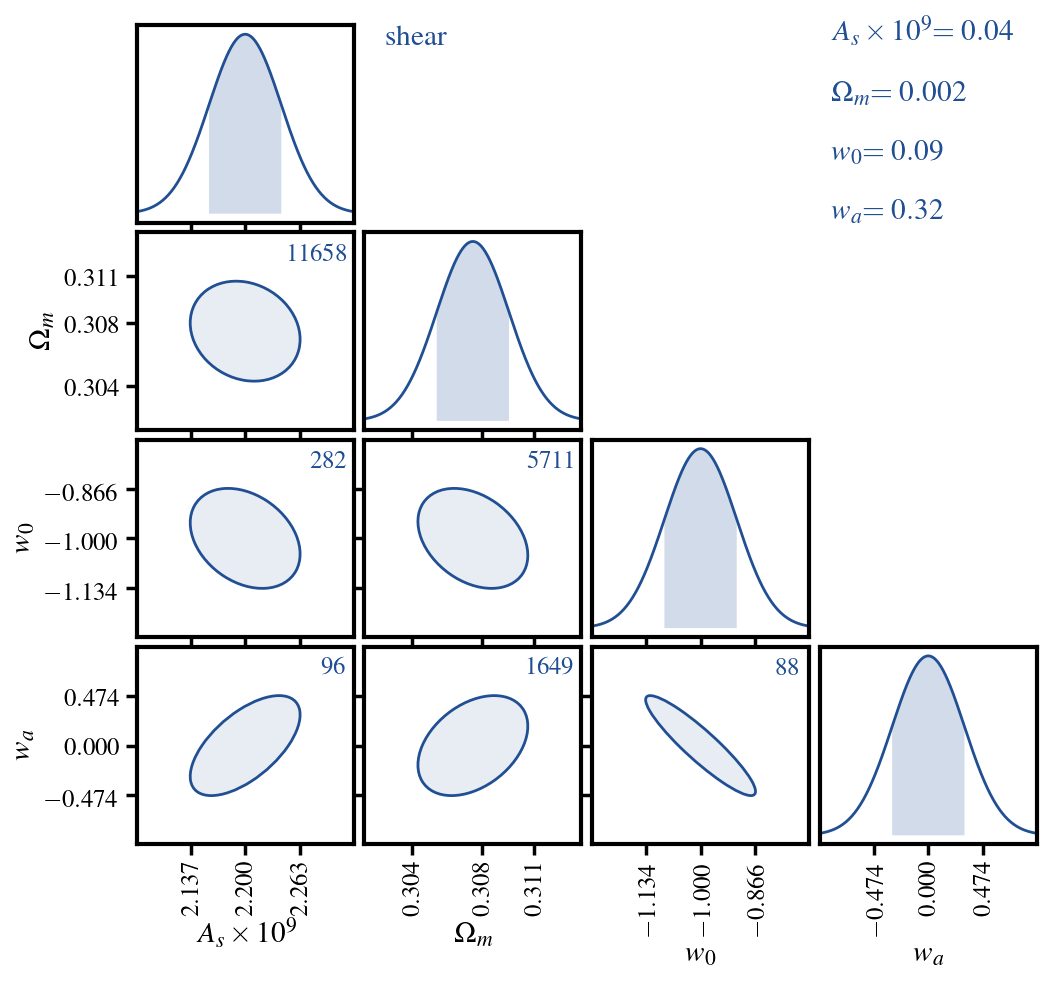

In [82]:
k='corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVFalse'
fish1 = fisher_tool(Fishers={0:fishes[k]['cov_p_inv']},pars={0:fishes[k]['params'],},par_cen=cosmo_fid#{'Om':0.28374511,'Ase9':0.80351633}
                    ,fisher_titles={0:'shear'})
f=fish1.plot_fish(pars=['Ase9','Om','w','wa'])

In [ ]:
k='corrs3_zmin0_barynQ0_pkfclass_pk_SSVTrue_pzpzb'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p_prior'][2:4,2:4]))
print('SSV B0',sn)

k='corrs3_zmin0_barynQ2_pkfclass_pk_SSVTrue_pzpzb'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p_prior'][2:4,2:4]))
print('SSV B2',sn)

k='corrs3_zmin0_barynQ0_pkfclass_pk_SSVFalse_pzpzb'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p_prior'][2:4,2:4]))
print('B0',sn)

k='corrs3_zmin0_barynQ2_pkfclass_pk_SSVFalse_pzpzb'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p_prior'][2:4,2:4]))
print(' B2',sn)


In [ ]:
# k='corrs3_zmin0.3_barynQ0_pkfclass_pk_SSVTrue_pzpzb'
# sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p_prior'][2:4,2:4]))
# print('SSV B0',sn)

k='corrs3_zmin0.3_barynQ2_pkfclass_pk_SSVTrue_pzpzb'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p_prior'][2:4,2:4]))
print('SSV B2',sn)

k='corrs3_zmin0_barynQ0_pkfclass_pk_SSVFalse_pzpzb'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p_prior'][2:4,2:4]))
print('B0',sn)

k='corrs3_zmin0_barynQ2_pkfclass_pk_SSVFalse_pzpzb'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p_prior'][2:4,2:4]))
print(' B2',sn)


In [ ]:
d=(fishes[k]['model']['As'][1]-fishes[k]['model']['As'][0])/(fishes[k]['x_vars']['As'][1]-fishes[k]['x_vars']['As'][0])

In [ ]:
np.sqrt(np.dot(fishes[k]['model']['As'][1],np.dot(fishes[k]['cov_inv'],fishes[k]['model']['As'][1])))

In [ ]:
fishes[k]['model_deriv']['As']@(fishes[k]['cov_inv']@fishes[k]['model_deriv']['As'])

In [ ]:
np.sqrt(1./3.9694333195083066e22)

In [ ]:
cc=kappa_class.cov_utils
corr_m=cc.corr_matrix(fishes[k]['cov'])
pcolor(corr_m,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
nbins

In [ ]:
k='corrs1_zmin0_barynQ0_pkfclass_pk_SSVTrue'
sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p'][2:4,2:4]))
sn

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes[k]['cov_p'][2:4,2:4]))
    ax.plot(sn,'ro')
    
ax.set_xscale('log')
ax.set_xlabel('$\sigma_z$')
ax.set_ylabel('DETF')


In [ ]:
nbins
corrs3_zmin0_barynQ2_pkfclass_pk_SSVTrue

In [ ]:
import PCA_shear
reload(PCA_shear)
from PCA_shear import *

In [ ]:
kappa_class=init_fish(corrs=corrs_iter[1],z_min=0,n_lens_bins=1,
                    nbins=nbins,pk_func='class_pk',SSV=True)
fish_bary=fisher_calc(cosmo_params=['As'],z_params=[],do_cov=False,do_log=False,
                                        kappa_class=kappa_class,galaxy_params=[],
                                          baryon_params=['Q0','Q1']
                                        )

In [ ]:
fishes['corrs1_pkfclass_pk_SSVFalse']['cov_p_inv'].shape

In [ ]:
crash

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
p_z=['B'] #,'sig0','sig1','sig2']
fishes_zsigma_pz0_prior={}
z_sigs=np.logspace(-2,0,5)
for zs in z_sigs:
    zs_bins_kwargs['z_sigma']=zs
    fishes_zsigma_pz0_prior[zs]=fisher_calc(cosmo_params=p,z_params=p_z,do_cov=False,do_log=False,priors=priors,
                                     cov_3X2_kwargs=cov_3X2_kwargs,#kappa_class=kappa_class,cl0=cl0,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
p_z=['b0','b1','b2'] #,'sig0','sig1','sig2']
fishes_zsigma_pz_prior={}
z_sigs=np.logspace(-2,0,5)
for zs in z_sigs:
    zs_bins_kwargs['z_sigma']=zs
    fishes_zsigma_pz_prior[zs]=fisher_calc(cosmo_params=p,z_params=p_z,do_cov=False,do_log=False,priors=priors,
                                     cov_3X2_kwargs=cov_3X2_kwargs,#kappa_class=kappa_class,cl0=cl0,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)

In [ ]:
k=0.01
sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz_prior[k]['cov_p'][2:4,2:4]))
print(k,sn)
sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz0_prior[k]['cov_p'][2:4,2:4]))
print(k,sn)
# sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz[0.05]['cov_p'][2:4,2:4]))
print(k,sn)
# sn=1./np.sqrt(np.linalg.det(fishes_zsigma[k]['cov_p'][2:4,2:4]))
# print(k,sn)

In [ ]:
crash

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
p_z=['b0','b1','b2'] #,'sig0','sig1','sig2']
#p=np.atleast_1d(['s8'])
fishes_zsigma_pz={}
z_sigs=np.logspace(-2,0,5)
for zs in z_sigs:
    zs_bins_kwargs['z_sigma']=zs
    fishes_zsigma_pz[zs]=fisher_calc(cosmo_params=p,z_params=p_z,do_cov=False,do_log=False,
                                     cov_3X2_kwargs=cov_3X2_kwargs,#kappa_class=kappa_class,cl0=cl0,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['z_sigma']=0.05

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
p_z=[]
#p=np.atleast_1d(['s8'])
fishes_zsigma={}
z_sigs=np.logspace(-2,0,5)
for zs in z_sigs:
    zs_bins_kwargs['z_sigma']=zs
    fishes_zsigma[zs]=fisher_calc(cosmo_params=p,z_params=p_z,do_cov=False,do_log=False,
                                  cov_3X2_kwargs=cov_3X2_kwargs,#kappa_class=kappa_class,cl0=cl0,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['z_sigma']=0.05

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zsigma.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'ro')
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz0_prior[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'go')
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pz_prior[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'mo')
    
    
ax.set_xscale('log')
ax.set_xlabel('$\sigma_z$')
ax.set_ylabel('DETF')
fname='sigmaz_detf'
# fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)
# yscale('log')

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_zsigma_pow={}
z_pow=[0,1,2]
for zp in z_pow:
    zs_bins_kwargs['z_sigma_power']=zp
    fishes_zsigma_pow[zp]=fisher_calc(cosmo_params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['z_sigma_power']=1

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zsigma_pow.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pow[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# ax.set_xscale('log')
ax.set_xlabel('$\sigma_z$ pow')
ax.set_ylabel('DETF')
fname='sigmaz_pow_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)
# yscale('log')

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_zmax={}
z_ms=[3] #[1,1.5,2,3]
for zm in z_ms:
    zs_bins_kwargs['zmax']=zm
    fishes_zmax[zm]=fisher_calc(cosmo_params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['zmax']=3

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_zmin={}
z_ms=[0.1,0.3,0.5]
for zm in z_ms:
    zs_bins_kwargs['zmin']=zm
    fishes_zmin[zm]=fisher_calc(cosmo_params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['zmin']=0.3

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zmax.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zmax[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
# ax.set_xlim(1.5,11)
# ax.set_ylim(120,145)
ax.set_xlabel('$z_{max}$')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='zmax_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zmin.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zmin[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
# ax.set_xlim(1.5,11)
# ax.set_ylim(120,145)
ax.set_xlabel('$z_{min}$')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='zmin_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_ell={}
ells=[1000,2000,5000]
for ell in ells:
    ell_bin_kwargs['lmax_cl']=ell
    fishes_ell[ell]=fisher_calc(cosmo_params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
ell_bin_kwargs['lmax_cl']=5000

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_ell.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_ell[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
# ax.set_xlim(1.5,11)
# ax.set_ylim(120,145)
ax.set_xlabel('$\ell_{max}$')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='ellmax_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
corrs_iter[0]

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_nb={}
nbs=[2,1,5,3]#10
# nbs=np.arange(10)+1
for nb in nbs:
    kappa_class=init_fish(corrs=corrs_iter[0],z_min=0,n_lens_bins=0,l_min=10,l_max=2000,Nl_bins=60,nbins=nb,
                    pk_func='class_pk',SSV=False)
    
    fishes_nb[nb]=fisher_calc(cosmo_params=p,do_cov=False,do_log=False,kappa_class=kappa_class)


In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_nb.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_nb[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
ax.set_xlim(1.5,11)
ax.set_ylim(140,200)
ax.set_xlabel('# tomographic bins')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='nbins_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
['b{i}'.format(i=i) for i in np.arange(3)]

In [ ]:
priors

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_nb_pz={}
# p_z=['b0','b1','b2'] #,'sig0','sig1','sig2']
zs_bins_kwargs['z_sigma']=0.05
nbs=[2,10,1,5,3]#10
# nbs=np.arange(10)+1
for nb in nbs:
    zs_bins_kwargs['nbins']=nb
    p_z=['b{i}'.format(i=i) for i in np.arange(nb)]
    fishes_nb_pz[nb]=fisher_calc(cosmo_params=p,z_params=p_z,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,zs_bins_kwargs=zs_bins_kwargs,priors=priors)
zs_bins_kwargs['nbins']=3

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_nb_pz.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_nb_pz[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'bo')
    
    sn=1./np.sqrt(np.linalg.det(fishes_nb[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'ro')
# xscale('log')
ax.set_xlim(1.5,11)
# ax.set_ylim(140,200)
ax.set_xlabel('# tomographic bins')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='nbins_detf_pz'
# fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
zl_bins['n_bins']

In [ ]:
priors

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_nb_pz_3x2={}
# p_z=['b0','b1','b2'] #,'sig0','sig1','sig2']
zs_bins_kwargs['z_sigma']=0.05
nbs=[2,1,5,3] #,10]
# nbs=np.arange(10)+1
cov_3X2_kwargs['corrs']=[corr_ll,corr_ggl,corr_gg]
b_z=['b1{i}'.format(i=i) for i in np.arange(zl_bins['n_bins'])]
for nb in nbs:
    zs_bins_kwargs['nbins']=nb
    p_z=['b{i}'.format(i=i) for i in np.arange(nb)]
    fishes_nb_pz_3x2[nb]=fisher_calc(cosmo_params=p,z_params=p_z,galaxy_params=b_z,
                                     do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,zs_bins_kwargs=zs_bins_kwargs,priors=priors)
cov_3X2_kwargs['corrs']=[corr_ll]
zs_bins_kwargs['nbins']=3

In [ ]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_nb_pz_2x2={}
# p_z=['b0','b1','b2'] #,'sig0','sig1','sig2']
zs_bins_kwargs['z_sigma']=0.05
nbs=[2,1,5,3] #,10]
# nbs=np.arange(10)+1
cov_3X2_kwargs['corrs']=[corr_ggl,corr_gg]
b_z=['b1{i}'.format(i=i) for i in np.arange(zl_bins['n_bins'])]
for nb in nbs:
    zs_bins_kwargs['nbins']=nb
    p_z=['b{i}'.format(i=i) for i in np.arange(nb)]
    fishes_nb_pz_2x2[nb]=fisher_calc(cosmo_params=p,z_params=p_z,galaxy_params=b_z,
                                     do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,zs_bins_kwargs=zs_bins_kwargs,priors=priors)
cov_3X2_kwargs['corrs']=[corr_ll]
zs_bins_kwargs['nbins']=3

In [ ]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_nb_pz_3x2.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_nb_pz[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'bo')
    
    sn=1./np.sqrt(np.linalg.det(fishes_nb[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'ro')
    
    sn=1./np.sqrt(np.linalg.det(fishes_nb_pz_3x2[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'mo')
    
    sn=1./np.sqrt(np.linalg.det(fishes_nb_pz_2x2[k]['cov_p'][2:4,2:4]))
    print(k,sn)
    ax.plot(k,sn,'go')

# xscale('log')
ax.set_xlim(1.5,11)
# ax.set_ylim(140,200)
ax.set_xlabel('# tomographic bins')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='nbins_detf_pz'
# fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
1./np.sqrt(np.linalg.det(fish['cov_p'][-2:,-2:]))

In [ ]:
fish['error']

In [ ]:
fish['error']

In [ ]:
m=fish['model']
ci=fish['cov_inv']
np.sqrt(np.dot(m,np.dot(ci,m)))

In [ ]:
np.linalg.eig(fish['cov_p'])